<a href="https://colab.research.google.com/github/andrewbhennessy/CS4641-Customer-Segmentation-Analysis/blob/main/Mid_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import datetime
import sklearn as skl
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Customer Data segmentation

Link to Our Data: https://www.kaggle.com/carrie1/ecommerce-data

How to Mount Data:
1. Follow the Instructions in the Auth Cell
2. Click the file icon
3. Navigate to drive then the folder that I have shared should be CS4641 something
4. right click on the file and copy path to the file and input into the next code cell as the first paramater in quotes. 

Example:


```
data = pd.read_csv('/content/drive/My Drive/CS4641 Customer Data Segmentation/data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
```



In [ ]:
init_df = pd.read_csv("/content/drive/My Drive/CS4641 Customer Data Segmentation/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})




# 1. Introduction/Background

> The COVID-19 pandemic has greatly affected the way all companies advertise for their businesses. Now more than ever, online presence and advertising are necessary to attract customers. While each customer is unique, a similar group of customers can be identified based on their purchase history. By grouping customers together based on recency, frequency, and monetary value we can create specific advertisements and incentives to maximize the revenue generated by a company. This is almost always more successful than creating generalized incentives and other types of advertisements aimed at the entire population.

# 2. Problem definition

> Our project will use customer spending datasets to group customers together based on 3 features: recency, frequency, and monetary value. This will allow advertising to become specialized to each cluster. With this, companies can target these groups and make advertisements and incentives specifically aimed at each of them. By analyzing the spending habits in each cluster, companies can more efficiently allocate their advertising funds.

# 3. Data Collection

> ## 3.1 Data Abstract
> ## 3.2 Data Cleaning Procedure
1. Remove Nan Customer ID datapoints
2. deal with negative quantities
3. Weight Discounts, Cancelled Orders, Regular orders 
>> ``` weights = {'D':0.5,'C':-1,'R':1} ```
4. Make new database based upon each customer with
>> 4.1 RFM Segmentation
>>> 4.1.1 Recency (how recent did customer buy from store?)
>>> 4.1.2 Frequency (how often did customer buy from store?)
>>> 4.1.3 Monetary (how much did customer spend?)
>> 4.2 divide into tiered groups (4 tiers)
>>> 4.2.1 K-means

> ## 3.3 Summary of Data


In [ ]:
init_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


After loading up our dataset, let's check for its size

In [ ]:
init_df.shape

(541909, 8)

As we can see, our initial dataset contains 541,909 total datapoints, each with 8 features. Now let's make sure our data is nice and clean. We are going to have to take our information given to construct a new dataset based upon the customers. If we are going to do that, then we can't be working with datapoints with a null (NaN) CustomerID. Let's check to see if there are any to remove. I found this snippet on stackoverflow that uses pandas to show null values 

In [ ]:
init_df[init_df.isnull().T.any().T]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


There are 135,080 null CustomerIDs, wow! Let's remove them all, thankfully we still have a ton of data to work with.

In [ ]:
init_df.dropna(subset=["CustomerID"], inplace=True)
init_df.drop_duplicates(inplace=True)

Now upon further analysis, It looks like some of the quantities in the dataset are < 0. Let's analyze this

In [ ]:
init_df[init_df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315,United Kingdom


We can see that there are over 8,000 orders that have negative quantity. From what it looks like, the 'C' inside the InvoiceNo means that this invoice has been canceled. There are also some special StockCodes like 'D' and 'M' that have negative quantities associated with it. There are three types of situations here. First, an order can be bought then canceled fully. Second, there could be orders that have negative quantity that aren't associated with a refund at all. Third, there could be orders that were bought then canceled partially. Let's take care of these 3 situations. Upon further research, our best method is to introduce a new feature which notates how many of that invoice's Quantity was refunded. This idea was inspired by Fabien Daniel's work in his Notebook on our same customer segmentation dataset. https://www.kaggle.com/fabiendaniel/customer-segmentation

In [ ]:
updated_df = init_df.copy(deep=True)
updated_df['QuantityRefunded'] = 0

remove_index_list = []

for index, row in init_df.iterrows():
    if row['Quantity'] < 0:
        #Finds all opposites for a given datapoint. There either won't be any (no match),
        #one match (full refund), or more than one (partial refund) we use .copy() so that we don't accidentally change the df
        refunded = init_df[(init_df['CustomerID'] == row['CustomerID']) & (init_df['StockCode'] == row['StockCode']) &
                           (init_df['InvoiceDate'] == row['InvoiceDate']) & (init_df['Quantity'] > 0)].copy()
        matches = refunded.shape[0] #number of rows represents how many matches we got
        
        if matches == 1:
            #full refund, update QuantityRefunded of the refunded datapoint and add current index to remove list
            updated_df.loc[refunded.index[0],'QuantityRefunded'] = -row['Quantity']
        else:
            #more than one match, find the latest index which fits the quantity 
            refunded.sort_index(axis=0 ,ascending=False, inplace = True)        
            for i, r in refunded.iterrows():
                if r['Quantity'] >= -row['Quantity']: 
                    updated_df.loc[i, 'QuantityRefunded'] = -row['Quantity']
                    break 
        remove_index_list.append(index)        

Now that we have found all the datapoints to remove / update the dataframe with, let's remove them and view our new feature. Let's also make sure that there are no longer any other quantities that are less than 0. While we are at it let's introduce another feature called 'Profit' that represents the total money gained from this purchase. This will be equal to ```UnitPrice * (Quantity - QuantityRefunded)```

In [ ]:
updated_df.drop(remove_index_list, inplace=True)
leftovers = updated_df[updated_df['Quantity'] < 0]
print('there are ', len(leftovers), ' leftovers in the dataset... removing them')
updated_df.drop(leftovers.index, inplace=True)
updated_df['Profit'] = updated_df['UnitPrice'] * (updated_df['Quantity'] - updated_df['QuantityRefunded'])

there are  0  leftovers in the dataset... removing them


We noticed earlier that there were some weird stock codes such as 'M' and 'D'. Let's make sure that there aren't anymore laying around, and if so, let's remove them!

In [ ]:
#get all unique stock code values
stonk_codes = updated_df[updated_df['StockCode'].str.contains('^[A-Za-z]+')]['StockCode'].unique()
updated_df = updated_df[~updated_df['StockCode'].isin(stonk_codes)]
stonk_codes

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

We can finally start to morph this dataset into a more customer-based one. After doing research, our team stumbled upon an interesting segmentation algorithm designed to be used for customer segmentation called RFM. You can read more about it at https://www.optimove.com/resources/learning-center/rfm-segmentation. In our final dataset, each customer is going to be given a score for Recency, Frequency, and Monetary. Recency represents how recent this customer last shopped using this e-commerce site. Frequency represents how often this customer shops using this e-commerce site. And Monetary will represent how much money this customer has spent on this e-commerce site.

Since this data is from the early 2010's, let's not find the recency with respect to 2020, but rather with respect to the chronologically last InvoiceDate.

In [ ]:
updated_df['InvoiceDate'] = pd.to_datetime(updated_df['InvoiceDate'])
latest = updated_df['InvoiceDate'].max() + datetime.timedelta(days=1)
latest

Timestamp('2011-12-10 12:50:00')

Using custom aggregations, we can pass a ditionary of functions for each feature into the ```.agg()``` function in order to build our RFM dataframe. We want to sum up all the ```Profit``` tags for each invoice all the while supplying a recency value for each invoice, then change our dataset to account for each customer's invoices' data using ```.agg()``` so we can correctly find each customers average Recency, total Frequency, and total Monetary

In [ ]:
#build recency 
try:
  rfm_df = pd.read_csv("/content/drive/My Drive/CS4641 Customer Data Segmentation/RFM.csv", encoding="ISO-8859-1", dtype={'CustomerID': int,'R': float, 'F':int, 'M':float})
except:
  recency_agg = {
      'Profit' : 'sum',
      'CustomerID' : lambda x : x.iloc[0], #lambda that returns the customerID, we use this to groupby later
      'InvoiceDate': lambda x : x.iloc[0] #lambda that returns the InvoiceDate
  }
  rfm_df = updated_df.groupby('InvoiceNo').agg(recency_agg) 
  rfm_df['R'] = pd.to_timedelta(latest - rfm_df['InvoiceDate']).astype('timedelta64[D]')
  frequency_monetary_agg = {
      'R' : 'mean', #recency agg, gets the average recency for when a customer last went to the shop
      'InvoiceDate' : lambda x : len(x), #frequency agg, gets how many invoices a customer made
      'Profit' : 'sum' #monetary agg, sums up all profits for every invoice a customer is associated with
  }
  rfm_df = rfm_df.groupby('CustomerID').agg(frequency_monetary_agg) #performs agg on a customer basis
  rfm_df.columns = ['R','F','M']
  try: 
    rfm_df.to_csv('/content/drive/My Drive/CS4641 Customer Data Segmentation/RFM.csv')
  except:
    print("Save Failure. Please check!!")
rfm_df

,CustomerID,R,F,M
0,12346,326.000000,1,77183.60
1,12347,183.714286,7,4310.00
2,12348,250.250000,4,1437.24
3,12349,19.000000,1,1457.55
4,12350,310.000000,1,294.40
...,...,...,...,...
4330,18280,278.000000,1,180.60
4331,18281,181.000000,1,80.82
4332,18282,67.000000,2,178.05
4333,18283,140.312500,16,2039.58


## Outlier Treatment 
> for Monetary Amount




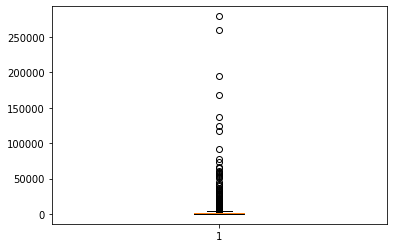

In [ ]:
# outlier treatment for Amount
plt.boxplot(rfm_df.M)
Q1 = rfm_df.M.quantile(0.25)
Q3 = rfm_df.M.quantile(0.75)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.M >= (Q1 - 1.5*IQR)) & (rfm_df.M <= (Q3 + 1.5*IQR))]

> Outlier Treatment for Frequency


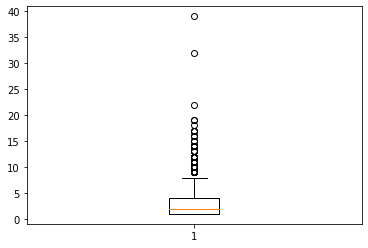

In [ ]:
# outlier treatment for Frequency
plt.boxplot(rfm_df.F)
Q1 = rfm_df.F.quantile(0.25)
Q3 = rfm_df.F.quantile(0.75)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.F >= Q1 - 1.5*IQR) & (rfm_df.F <= Q3 + 1.5*IQR)]

> Outlier Treatment for Recency

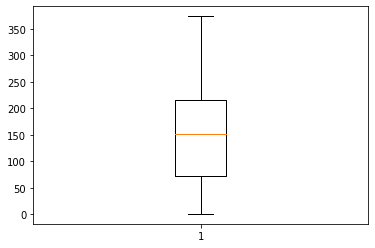

In [ ]:
# outlier treatment for Recency
plt.boxplot(rfm_df.R)
Q1 = rfm_df.R.quantile(0.25)
Q3 = rfm_df.R.quantile(0.75)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.R >= Q1 - 1.5*IQR) & (rfm_df.R <= Q3 + 1.5*IQR)]

> Summary of RFM after Outlier Treatment for R,F,M

In [ ]:
rfm_df.head()

,CustomerID,R,F,M
2,12348,250.250000,4,1437.24
3,12349,19.000000,1,1457.55
4,12350,310.000000,1,294.40
5,12352,185.285714,7,1385.74
6,12353,204.000000,1,89.00


> ## Scaling our RFM Data


In [ ]:
# standardise all parameters
RFM_norm1 = rfm_df.drop(["CustomerID"], axis=1)

standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [ ]:
 RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['R','F','M']
RFM_norm1.head()

,R,F,M
0,1.030988,0.805398,0.845935
1,-1.445647,-0.851483,0.873060
2,1.670897,-0.851483,-0.680388
3,0.335235,2.462279,0.777154
4,0.535661,-0.851483,-0.954711


# 4. Methods (K-MEANS)

> We will be testing K-means to specify our groups. Using this method, points are assigned to their nearest centroid based on their Euclidean distance. The points assigned to the same centroid form a cluster. After the clusters are formed, a new centroid is calculated for each cluster by taking the mean of the cluster. This is repeated until the centroids can no longer move any further. K-means will include all data points in its clustering groups. The Elbow method can be used to find the optimal number of clusters. A disadvantage to K-means is that the cluster groups will all be more or less circular, whereas other forms of clustering can create irregular-shaped cluster groups.

> Visualization

In [ ]:
model = KMeans(n_clusters = 3, max_iter=50)
clusters = model.fit_predict(RFM_norm1)

In [ ]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'R -->'),yaxis = dict(title  = 'F--->'),zaxis = dict(title  = 'M -->'))

x = RFM_norm1[['R','F','M']].values

labels = clusters
trace = go.Scatter3d(x=x[:, 0], y=x[:, 1], z=x[:, 2], mode='markers',marker=dict(color = labels, size= 3, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

# 5 Results (See 6 Discussion for results in context)
> Silhouette Analysis


In [ ]:
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

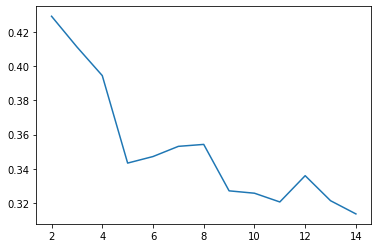

In [ ]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

> Sum of Squared Distances

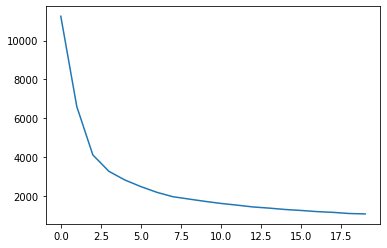

In [ ]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

# 6. Discussion

>In addition to our initial plan of categorizing customers with only DBScan, we decided to implement K-means analysis as well to vividly depict which method offers the most practical result. Prior to applying any clustering methods, we introduced a new powerful method called RFM segmentation into our dataset. After undergoing multiple data cleaning processes and calculations for RFM segmentation, we finalized our dataset so that each data point (customer) has three features: recency, frequency and monetary. Using these three features, we applied K-means clustering analysis to group each customer into a certain number of clusters. In order to test for the optimal number of clusters, we visualized silhouette coefficients for over a range from 2 to 15 clusters as well as the sum of squared distances for elbow test. After analyzing two graphs, we figured the optimal number of clusters for our current dataset to be about 3 with a silhouette coefficient around 0.4. The ideal value for silhouette coefficient is to be as close to 1 as possible, and we figured there may be a possible way to improve our value. Therefore, we plan to revisit our preprocessing of the data, and a potential revision we will be making is changing the average recency to incorporate the most and least recent purchases for each customer ID.

>The three final clusters refer to different type of customers. The red cluster from the graph depicts a group of customers who spent small amount of money and have not shopped recently or frequently. The blue cluster represents a group similar to the red cluster but those who shopped recently. Finally, the yellow cluster is a group of customers who frequently spent large amount of money in a decently recent time frame. However, the yellow cluster covers large area so there may be many customers who may not be frequent or recent customers. The highest priority of targeted incentives will be the red group since they need to be attracted the most, followed by the blue group and the yellow group. The blue group has fairly high recency score, so we need to convert them to be our frequent shoppers and lead them to spend more money by endeavoring to introduce a variety of expensive items related to their previous purchases. Lastly, the yellow group is the group of best customers who heavily contribute to the company’s overall revenue. The main target for this group is to encourage them to be remain as regular shoppers by optimizing their experience and showing appreciation for their purchases. 

>Although we managed to deal with outliers in our data through outlier treatment process, K-means method is heavily influenced by outliers since the location of centroids may be dragged which can lead to skewed clusters. Therefore, we decided to implement another analysis using density based spatial clustering (DBSCAN) in the future for our final project to compare which method provides more pragmatic outcome in the end. DBSCAN has an advantage of not depending on outliers but it may not be effective for a dataset with a similar size of density.


# 7 References

> 1.  Hossain, Shahadat. “Customer Segmentation Using Centroid Based and Density Based Clustering Algorithms.” Customer Segmentation Using Centroid Based and Density Based Clustering Algorithms - IEEE Conference Publication, 1 Feb. 2018, ieeexplore.ieee.org/document/8275249.

> 2. Modukuru, Pranay. “Customer Segmentation and Acquisition Using Machine Learning.” Medium, Towards Data Science, 19 Apr. 2020, towardsdatascience.com/customer-segmentation-and-acquisition-using-machine-learning-a219ce0ec139.

> 3. Sekhar, Babu B, and Prasanna P Lakshmi. “Customer Data Clustering Using Density Based Algorithm.” Research Gate, International Journal of Engineering & Technology, May 2018, www.researchgate.net/publication/325881992_Customer_Data_Clustering_using_Density_based_algorithm.